# Gene Expression Analysis of Neurons Under Stress
Dataset : GSE283582 ( NCBI GEO ) 

Objective : To identify stress-responsive genes in neurons by comparing sleep (normal/controlled) and sleep-deprived (stress) conditions using explicit log2 fold-change–based differential expression analysis.

This notebook focuses on:
- Data loading and quality control
- Calculation of log2 fold change
- Exploratory identification of stress-responsive genes
- Visualization of expression patterns through various plots
- Preparing data for statistical analysis in R (DESeq2) (Part-2 of this project that will be continued in R Scripts)

Author : Surbhi Yadav

Reference - Yamazaki S, Valekunja UK, Chen-Roetling J, Reddy AB. Heat Shock Factor 1 Governs Sleep-Wake Cycles Across Species. bioRxiv [Preprint]. 2024 Nov 17:2024.11.15.623879. doi: 10.1101/2024.11.15.623879. PMID: 39605613; PMCID: PMC11601485.

In [1]:
import os as os
import gzip as gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Python 3.14 environment ready")

plt.rcParams["figure.figsize"] = (7,5)
sns.set_style("whitegrid")

Python 3.14 environment ready


In [2]:
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
RAW_DATA = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
RESULTS = PROJECT_ROOT / "results"
FIGURES = RESULTS / "figures"
TABLES = RESULTS / "tables"

RAW_DATA.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

In [3]:
#load raw count matrix
RAW_DATA = "../data/raw"
file_path = os.path.join(RAW_DATA, "GSE283582_gene_count_matrix.csv.gz")

with gzip.open(file_path,"rt") as f:
    counts = pd.read_csv(f,index_col=0)
counts.head()

,ZT6_Ctl1,ZT6_Ctl2,ZT6_Ctl3,ZT6_SD1,ZT6_SD2,ZT6_SD3
gene_id,,,,,,
ENSMUSG00000102348|Gm10568,8,8,3,7,15,6
ENSMUSG00000102269|Gm7357,0,0,4,8,0,0
ENSMUSG00000104328|Gm37323,0,3,0,0,0,0
ENSMUSG00000102175|Gm6119,5,0,0,2,0,0
ENSMUSG00000025902|Sox17,98,248,294,254,250,134


In [4]:
#initial data check
counts.shape
counts.info()

<class 'pandas.DataFrame'>
Index: 57010 entries, ENSMUSG00000102348|Gm10568 to ENSMUSG00002076890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ZT6_Ctl1  57010 non-null  int64
 1   ZT6_Ctl2  57010 non-null  int64
 2   ZT6_Ctl3  57010 non-null  int64
 3   ZT6_SD1   57010 non-null  int64
 4   ZT6_SD2   57010 non-null  int64
 5   ZT6_SD3   57010 non-null  int64
dtypes: int64(6)
memory usage: 3.0+ MB


In [5]:
#filter lowly expressed genes

min_counts = 10
min_samples = 3

filtered_counts = counts[(counts >=min_counts).sum(axis=1) >= min_samples 
]
filtered_counts.shape

(20107, 6)

In [6]:
#column names
print(counts.columns.tolist()[:20])
print("Total samples:", len(counts.columns))

['ZT6_Ctl1', 'ZT6_Ctl2', 'ZT6_Ctl3', 'ZT6_SD1', 'ZT6_SD2', 'ZT6_SD3']
Total samples: 6


In [7]:
#define sample groups
sample_names = counts.columns.tolist()
sample_info = pd.DataFrame({"sample": sample_names})
sample_info.head()

,sample
0,ZT6_Ctl1
1,ZT6_Ctl2
2,ZT6_Ctl3
3,ZT6_SD1
4,ZT6_SD2


In [8]:
#define experimental conditions
sleep_samples = sample_info.iloc[0:3]["sample"].tolist()
stress_samples = sample_info.iloc[3:6]["sample"].tolist()

In [9]:
#mean expression per condition
sleep_mean = filtered_counts[sleep_samples].mean(axis=1)
stress_mean = filtered_counts[stress_samples].mean(axis=1)

In [10]:
#log2 fold change 
log2_fc = np.log2((stress_mean + 1) / (sleep_mean + 1))

In [11]:
#fold change table 
fc_table = pd.DataFrame({ 
    "Sleep_mean": sleep_mean,
    "Stress_mean": stress_mean,
    "log2FoldChange": log2_fc
})

fc_table.head()

,Sleep_mean,Stress_mean,log2FoldChange
gene_id,,,
ENSMUSG00000025902|Sox17,213.333333,212.666667,-0.004494
ENSMUSG00000098104|Gm6085,13.666667,8.333333,-0.652077
ENSMUSG00000051951|Xkr4,1677.666667,1444.333333,-0.215914
ENSMUSG00000102331|Gm19938,38.333333,27.000000,-0.490326
ENSMUSG00000033774|Npbwr1,74.000000,35.666667,-1.032421


In [12]:
#identify stress-responsive genes 
stress_responsive = fc_table[
    abs(fc_table["log2FoldChange"]) >= 1
    ].sort_values("log2FoldChange",ascending=False)

stress_responsive.head()

,Sleep_mean,Stress_mean,log2FoldChange
gene_id,,,
ENSMUSG00000086773|Gm16192,0.000000,92.333333,6.544321
ENSMUSG00000114067|Gm47065,11.666667,338.666667,4.745011
ENSMUSG00000116069|Gm49510,28.333333,343.333333,3.553193
ENSMUSG00000054545|Ugt1a6a,8.000000,84.666667,3.250737
ENSMUSG00000070392|Gm20634,35.666667,301.333333,3.043599


In [13]:
#save python log2fc results

stress_responsive.to_csv(
    os.path.join(TABLES, "log2FC_stress_genes_python.csv")
)


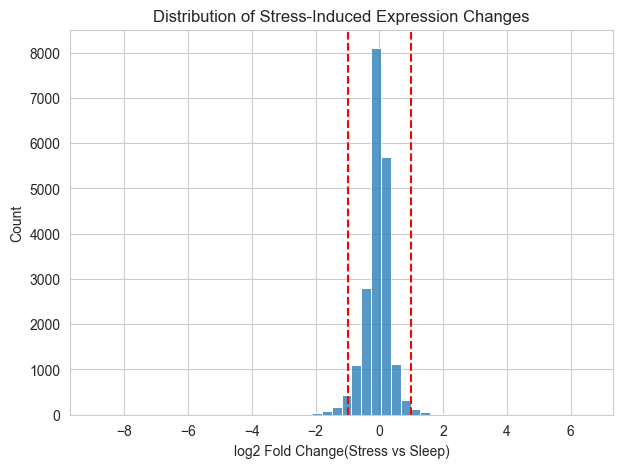

In [14]:
#log2 fold change distribution

sns.histplot(fc_table["log2FoldChange"],bins=50)
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--",color="red")
plt.xlabel("log2 Fold Change(Stress vs Sleep)")
plt.title("Distribution of Stress-Induced Expression Changes")
plt.savefig(os.path.join(FIGURES, "log2_foldchange_distribution_python.png"),dpi=300,bbox_inches="tight")
plt.show()

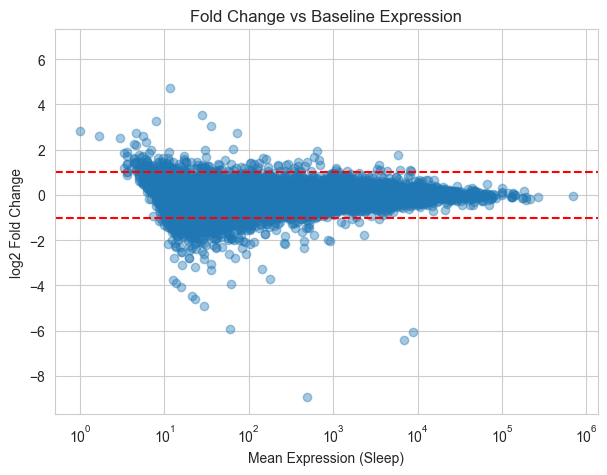

In [15]:
#fold change vs baseline expression

plt.scatter(
    sleep_mean,
    log2_fc,
    alpha=0.4
)

plt.axhline(1, linestyle="--",color="red")
plt.axhline(-1, linestyle="--",color="red")
plt.xscale("log")
plt.xlabel("Mean Expression (Sleep)")
plt.ylabel("log2 Fold Change")
plt.title("Fold Change vs Baseline Expression")
plt.savefig(os.path.join(FIGURES, "fold_change_vs_baseline_expression_python.png"),dpi=300,bbox_inches="tight")
plt.show()

In [16]:
#log transformation for heatmap

log_counts = np.log2(filtered_counts + 1)

<function matplotlib.pyplot.show(close=None, block=None)>

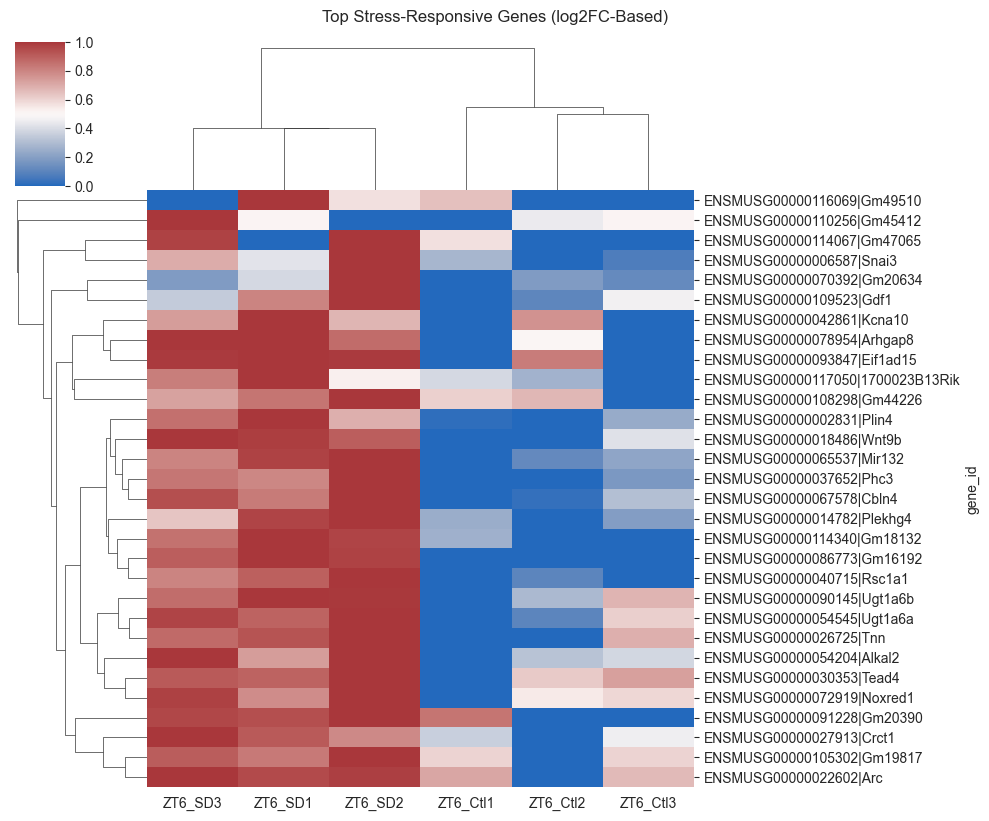

In [17]:
#heatmap !! 
top_genes = stress_responsive.head(30).index
heatmap_data = log_counts.loc[top_genes]

sns.clustermap(
    heatmap_data,
    cmap="vlag",
    standard_scale=0,
    figsize=(10,8)
)

plt.suptitle("Top Stress-Responsive Genes (log2FC-Based)",y=1.02)
plt.savefig(os.path.join(FIGURES, "top_stress_responsive_genes_python.png"),dpi=300,bbox_inches="tight")
plt.show

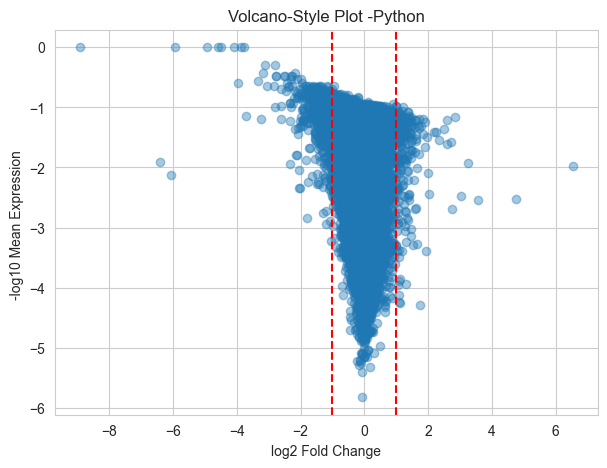

In [18]:
#volcano-style plot 

plt.scatter(
    log2_fc,
    -np.log10(stress_mean + 1),
    alpha=0.4
)

plt.axvline(1,linestyle="--", color="red")
plt.axvline(-1,linestyle="--",color="red")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 Mean Expression ")
plt.title("Volcano-Style Plot -Python")
plt.savefig(os.path.join(FIGURES, "volcano_style_plot_python.png"),dpi=300,bbox_inches="tight")
plt.show()

In [19]:
#export counts for Deseq2 - R 

filtered_counts.to_csv(os.path.join(PROCESSED_DATA,"counts_for_DESeq2.csv")
)

In [20]:
#Thank you now lets switch to R !! 
